In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
import os
import joblib
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix, classification_report

# Set directory
base_dir = './sets'
# Load validation set and test set
X_val = np.load(f'{base_dir}/X_val.npy')
y_val = np.load(f'{base_dir}/y_val.npy')
X_test = np.load(f'{base_dir}/X_test.npy')
y_test = np.load(f'{base_dir}/y_test.npy')

# load best sets
over_sampled_best_X_val = np.load(f'{base_dir}/over_sampled_best_X_val.npy')
under_sampled_best_X_val = np.load(f'{base_dir}/under_sampled_best_X_val.npy')
over_sampled_best_X_test = np.load(f'{base_dir}/over_sampled_best_X_test.npy')
under_sampled_best_X_test = np.load(f'{base_dir}/under_sampled_best_X_test.npy')

# make output directory
output_dir = './deeplearning_out'
os.makedirs(output_dir, exist_ok=True)

n_features = X_val.shape[1]
n_best_over_features = over_sampled_best_X_val.shape[1]
n_best_under_features = under_sampled_best_X_val.shape[1]

# Tuning Hyperparameters

In [20]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(n_features,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# UnderSampled Set

Reloading Tuner from ./deeplearning_out/under_no_sel_deepL/tuner0.json
Epoch 1/100


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6754 - loss: 1.1614 - val_accuracy: 0.9820 - val_loss: 0.0929
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9624 - loss: 0.1397 - val_accuracy: 0.9252 - val_loss: 0.2307
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9710 - loss: 0.0985 - val_accuracy: 0.9518 - val_loss: 0.1553
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9778 - loss: 0.0638 - val_accuracy: 0.9495 - val_loss: 0.1574
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9785 - loss: 0.0558 - val_accuracy: 0.9523 - val_loss: 0.1476
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9895 - loss: 0.0325 - val_accuracy: 0.9389 - val_loss: 0.1840
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9880 - loss: 0.0371 - val_accuracy: 0.9472 - val_loss: 0.1660
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9964 - loss: 0.0224 - val_accuracy: 0.9495 - val_

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step - accuracy: 0.9812 - loss: 0.0957
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 527us/step


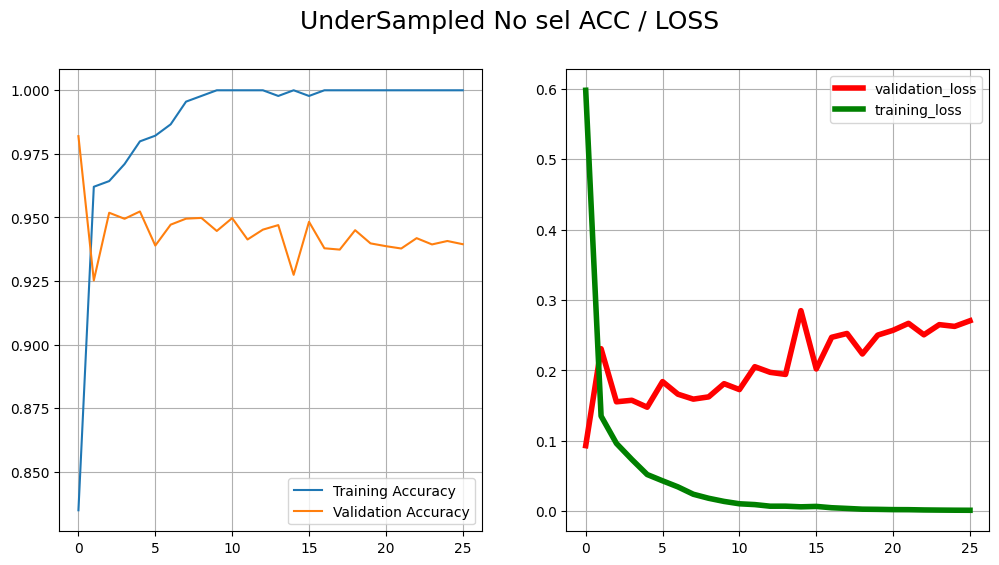

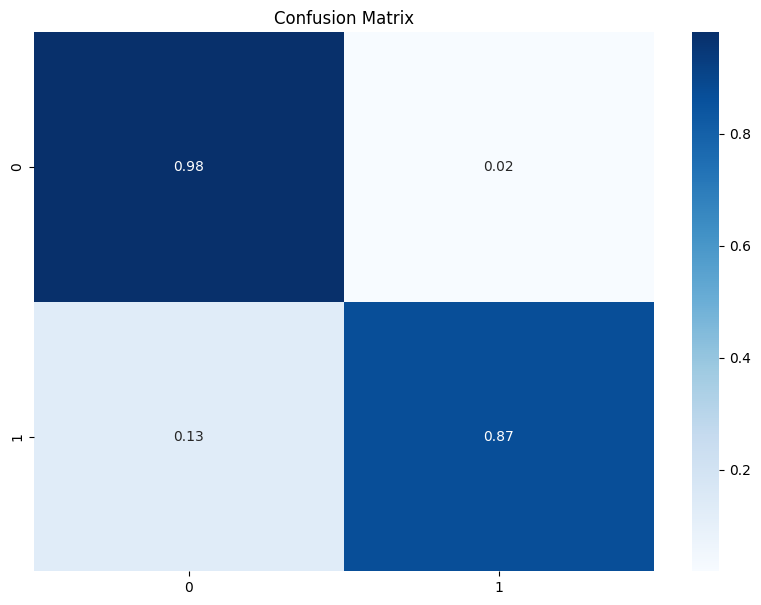

In [21]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_no_sel_deepL'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


x_train = np.load(f'{base_dir}/under_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_model = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_model)
history = model.fit(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_no_sel', exist_ok=True)

model.save(f'{output_dir}/under_no_sel/model.h5')
with open(f'{output_dir}/under_no_sel/history.json', 'w') as f:
    json.dump(history.history, f)
with open(f'{output_dir}/under_no_sel/best_model.json', 'w') as f:
    json.dump(best_model.values, f)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

with open(f'{output_dir}/under_no_sel/test_results.json', 'w') as f:
    json.dump({'test_loss': test_loss, 'test_acc': test_acc}, f)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Plot of Training and Validation Accuracy/Loss

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# OverSampled Set

In [22]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu',
                    input_shape=(n_features,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Reloading Tuner from ./deeplearning_out/over_no_sel_deepL/tuner0.json
Epoch 1/100


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 788us/step - accuracy: 0.9837 - loss: 0.0661 - val_accuracy: 0.9986 - val_loss: 0.0101
Epoch 2/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 713us/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 0.9988 - val_loss: 0.0092
Epoch 3/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 704us/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9992 - val_loss: 0.0065
Epoch 4/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 712us/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0075
Epoch 5/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 712us/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9992 - val_loss: 0.0083
Epoch 6/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 708us/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9992 - val_loss: 0.0084
Epoch 7/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 728us/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9993 - val_loss: 0.0078
Epoch 8/100
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 710us/step - accuracy: 0.9996 - los

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step - accuracy: 0.9988 - loss: 0.0104
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 531us/step


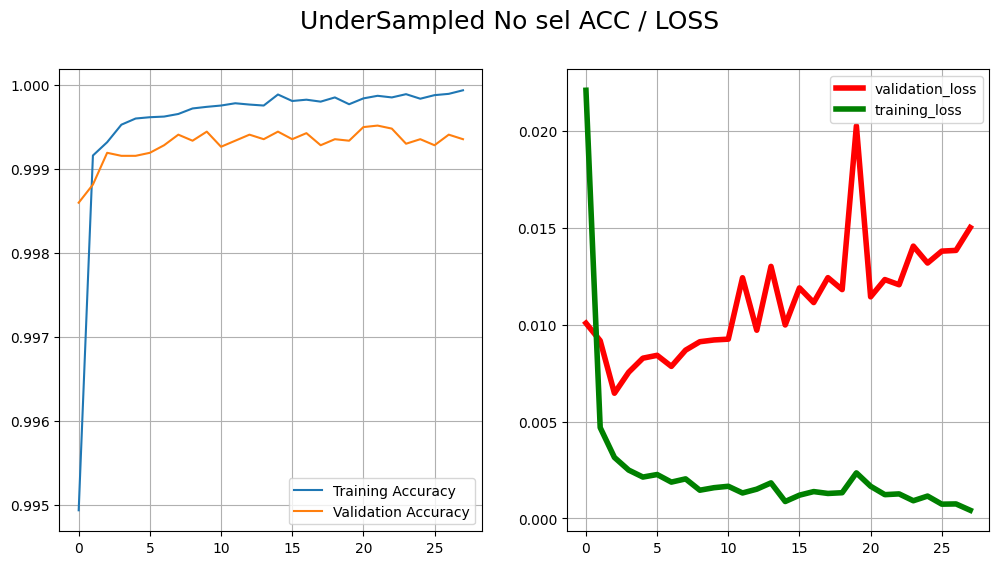

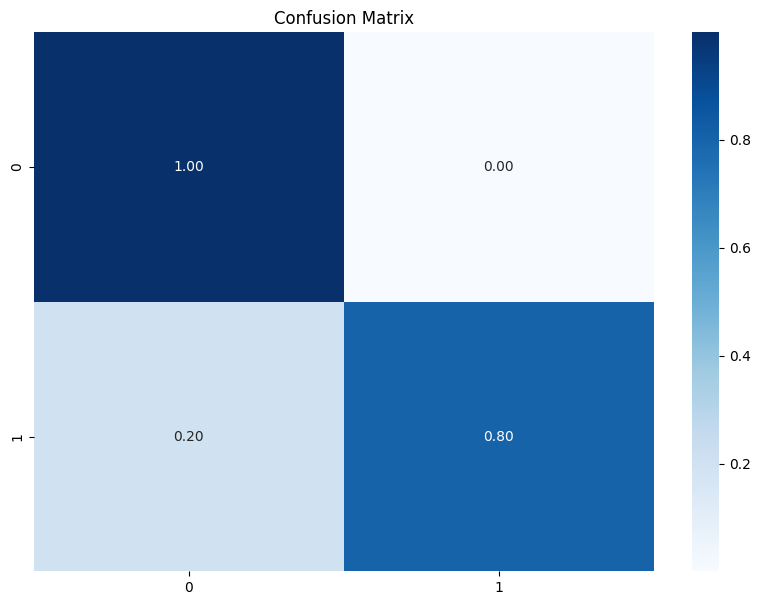

In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_no_sel_deepL'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


x_train = np.load(f'{base_dir}/over_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_model = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_model)
history = model.fit(x_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_no_sel', exist_ok=True)

model.save(f'{output_dir}/over_no_sel/model.h5')
with open(f'{output_dir}/over_no_sel/history.json', 'w') as f:
    json.dump(history.history, f)
with open(f'{output_dir}/over_no_sel/best_model.json', 'w') as f:
    json.dump(best_model.values, f)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

with open(f'{output_dir}/over_no_sel/test_results.json', 'w') as f:
    json.dump({'test_loss': test_loss, 'test_acc': test_acc}, f)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Plot of Training and Validation Accuracy/Loss

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()